In [1]:
%load_ext lab_black
%load_ext autotime

import drnb.embed.pipeline as pl

time: 7.45 s (started: 2022-11-19 19:57:04 -08:00)


## neg-t-SNE

In [Contrastive learning unifies t-SNE and UMAP](https://arxiv.org/abs/2206.01816) ([github repo](https://arxiv.org/abs/2103.14608)) Damrich and co-workers describe t-SNE and UMAP-like methods in terms of a contrastive learning cost function (the "generalized NCE loss"). In their paper, they refer to the use of the generalized NCE loss with the Cauchy kernel for dimensionality reduction as neg-t-SNE. (If you aren't familiar with UMAP or how its implemented, this isn't going to make a lot of sense, so sorry in advance)

### Cost function

The cost function for the "positive" pair of items $i,j$ is:

$$
C^+_{\mathrm{neg{\text -}t{\text -}SNE}} = - \log \left( \frac{w_{ij}}{w_{ij} + \bar{Z}m\xi} \right) 
$$

and for negative pairs, it's:

$$
C^-_{\mathrm{neg{\text -}t{\text -}SNE}} = -\log \left( 1 - \frac{w_{ij}}{w_{ij} + \bar{Z}m\xi} \right)
$$

$w_{ij}$ is the usual low-dimensional output weight/similarity:

$$
w_{ij} = \frac{1}{1 + d_{ij}^2}
$$

and $d_{ij}$ is the Euclidean distance between points $i$ and $j$ in the output embedding. $m$ is the negative sampling frequency, i.e. the number of negative samples used for every positive sample. For UMAP, that's 5, although bear in mind that this paper (and a [previous publication](https://arxiv.org/abs/2103.14608)) has something to say about that. But we can say for neg-t-SNE $m=5$. $\xi$ represents the negative sampling distribution which for UMAP (although not LargeVis) is uniform sampling, so $\xi$ is the reciprocal of all possible pairs of the data and hence:

$$
\xi = \frac{2}{N \left( N - 1 \right)}
$$

Finally, $\bar{Z}$ is the partition function, which for neg-t-SNE is held constant (compared to NCVis, where it becomes a free parameter which is optimized along with the coordinates). Larger values produce more compressed clusters in the output. If you set $\bar{Z} = 1 / m\xi =  \left[N(N-1)\right]/2m$ (a rather large number), you get $\bar{Z}m\xi=1$ and something close to UMAP, although bear in mind you are using a non-default output kernel with $a=1, b=1$. Larger values of $\bar{Z}$ get NCVis-like output and larger still produce something closer to t-SNE, although to my eyes, you also need a much larger value of $m$ for it to really look like t-SNE, and at least for the typical implementation of UMAP, that results in rather long run-times.

### Gradient

The "force constant" bits of the attractive and negative parts of the gradient (i.e. without the displacement $\mathbf{y}_i - \mathbf{y}_j$) are, respectively:

$$
k^{+}_{ij} = \frac{2 \bar{Z} m \xi w_{ij}}{w_{ij} + \bar{Z} m \xi} \\
k^{-}_{ij} = -\frac{2 w_{ij}^2}{w_{ij} + \bar{Z} m \xi}
$$

i.e. this is the sort of thing you would replace the original definition of `grad_coeff` in the [UMAP source code](https://github.com/lmcinnes/umap/blob/615cb1adf3611d6c138f3794a8202bbf339587a2/umap/layouts.py#L135) with these versions, give or take the negative sign which could change depending on where other negative signs in e.g. the displacement or gradient descent get folded in.

### Annealed learning rate

Also, the authors of the paper provide some evidence that using the neg-t-SNE formulation of UMAP should be more numerically stable, because the standard UMAP repulsive gradient diverges for small $d_{ij}^2$. Neg-t-SNE doesn't have this divergence in its gradient and annealing the learning rate seems un-necessary compared to UMAP.

### Implementation

I have hacked together a version of neg-t-SNE by making some modifications to UMAP, which you can use by specifying the `"negtsne"` embedder. The paper says for more t-SNE-like results, it was necessary to initialize from the UMAP-like results, so in the code I have merely used the UMAP-like $\bar{Z}$ for the first 200 epochs. As a result, you should probably double the number of epochs you would otherwise use. Below I always use `n_epochs = 700`, as 200 epochs at the final value of $\bar{Z}$ doesn't seem to give very converged results.

Of note:

* `repulsion_strength`: use to specify $\bar{Z}$.
* `anneal_lr`: set to `True` to anneal the learning rate like with standard UMAP. By default, this is set to `False` because it seems it should not be necessary.

### Partition Function: t-SNE

For MNIST, the paper suggests a value for $\bar{Z} = 8.1 \cdot 10^6$:

#### Annealed learning rate

[19:58:04] INFO     Loading faiss with AVX2 support.                                                   ]8;id=580508;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=681004;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=758617;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=91124;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=145499;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=976645;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=639808;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=95604;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

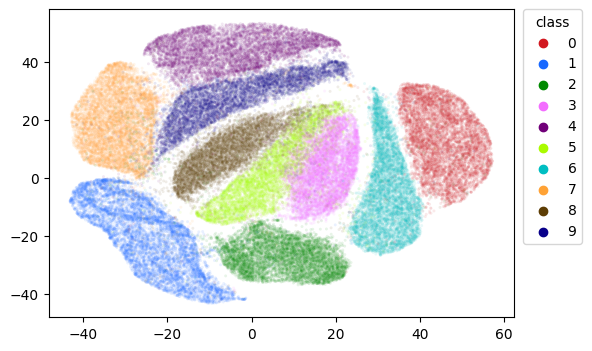

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6177285714285714, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3463928285972961, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.10109714285714284, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.16152514285714287, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.24354152380952385, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min (started: 2022-11-19 19:57:11 -08:00)


In [2]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne", params=dict(repulsion_strength=8.1e6, n_epochs=700, anneal_lr=True)
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

#### Constant learning rate

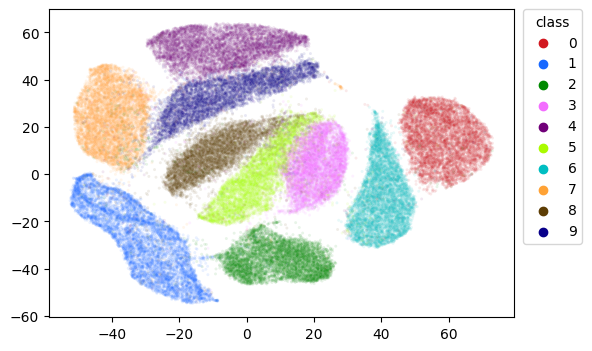

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6150914285714286, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.343177557426196, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.09933809523809524, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.16406257142857145, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2503477142857143, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 57.2 s (started: 2022-11-19 19:58:11 -08:00)


In [3]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne", params=dict(repulsion_strength=8.1e6, n_epochs=700, anneal_lr=False)
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

### Partition Function: NCVis

For MNIST, the paper suggests a value for $\bar{Z} = 3.4 \cdot 10^7$:

#### Annealed learning rate

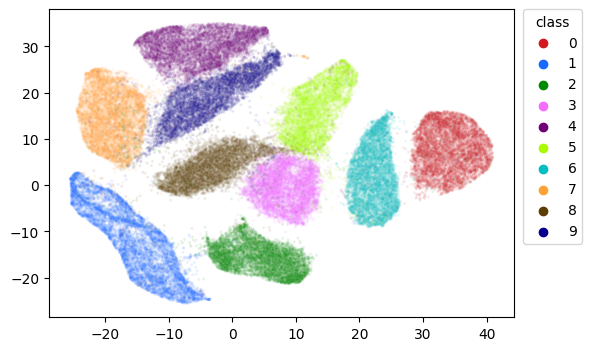

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6136628571428573, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.34010840288728467, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.10905904761904761, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.17241857142857145, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.25863438095238095, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 59.9 s (started: 2022-11-19 19:59:08 -08:00)


In [4]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne", params=dict(repulsion_strength=3.4e7, n_epochs=700, anneal_lr=True)
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

#### Constant learning rate

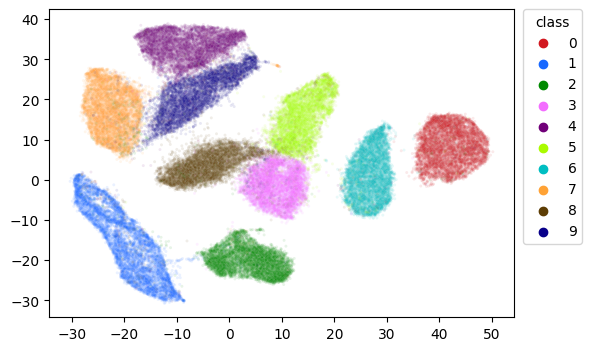

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6150800000000001, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.35023485389196835, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.09242761904761905, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.15751657142857145, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.24700714285714287, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min (started: 2022-11-19 20:00:08 -08:00)


In [5]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne", params=dict(repulsion_strength=3.4e7, n_epochs=700, anneal_lr=False)
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

### Partition Function: UMAP

To get something UMAP-like, we want $\bar{Z} = 1 / m\xi$, which for standard UMAP settings and MNIST comes out to $\bar{Z} = 4.9 \cdot 10^8$

#### Annealed learning rate

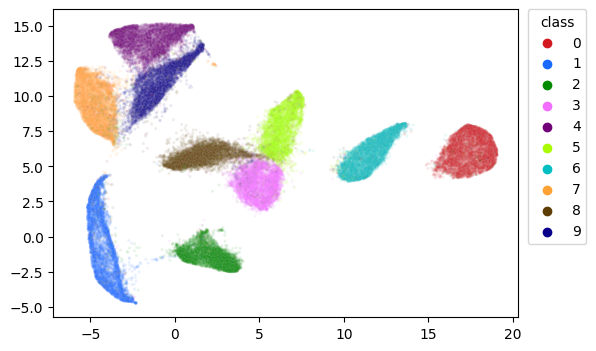

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6155914285714286, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.37297787491386425, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.0985495238095238, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.1595851428571429, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.24562257142857144, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 48.3 s (started: 2022-11-19 20:01:09 -08:00)


In [6]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne", params=dict(repulsion_strength=4.9e8, n_epochs=700, anneal_lr=True)
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

#### Constant learning rate

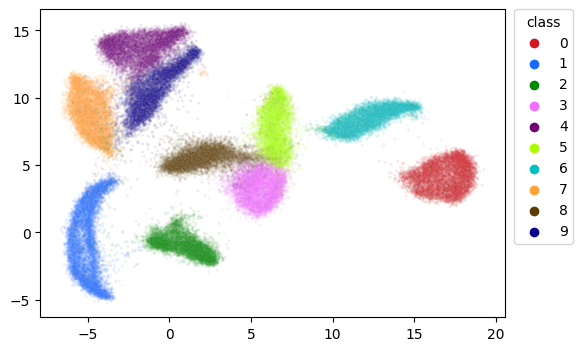

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6145457142857143, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.36877942848725453, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.021950476190476194, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.05775057142857143, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.12919904761904763, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 58.4 s (started: 2022-11-19 20:01:57 -08:00)


In [7]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne", params=dict(repulsion_strength=4.9e8, n_epochs=700, anneal_lr=False)
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

Hmm. The fuzziness of the results here reminds me of the results in the paper where the UMAP reference implementation was modified to turn off the annealing of the learning rate. We shouldn't really see this with neg-t-SNE if it's the diverging gradient that causes this. It *could* be also be due to the constant learning rate being too high. Here's the result where the learning is halved:

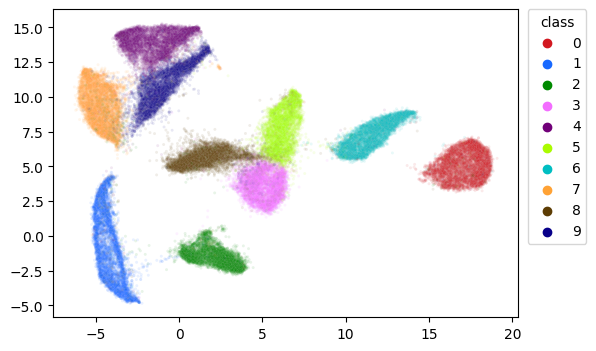

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6159028571428571, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.37493066746100134, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.06244190476190475, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.11830085714285717, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.20583809523809526, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 56.7 s (started: 2022-11-19 20:02:56 -08:00)


In [8]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne",
        params=dict(
            repulsion_strength=4.9e8, n_epochs=700, anneal_lr=False, learning_rate=0.5
        ),
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

This does seem improved. We don't see this effect with smaller values of $\bar{Z}$ but we *do* see convergence issues around having to use a larger number of epochs so an alternative explanation could be that a constant learning rate stochastic gradient descent needs more careful tuning of the learning rate depending on the relative weight of the repulsive and attractive interactions (and perhaps the dataset size). But as I don't really want to do all the work that would be required to get a better idea of what might be going on, I will leave this as an open question for now.

In terms of choosing a good value for $\bar{Z}$ that does seem awkward, as it interacts with both the number of negative samples and more importantly, the number of pairs in the dataset, which is obviously highly dataset dependent. Here's an attempt at using $\bar{Z} = 8.1 \cdot 10^6$, the t-SNE-like value for MNIST with the much smaller `s1k` dataset:

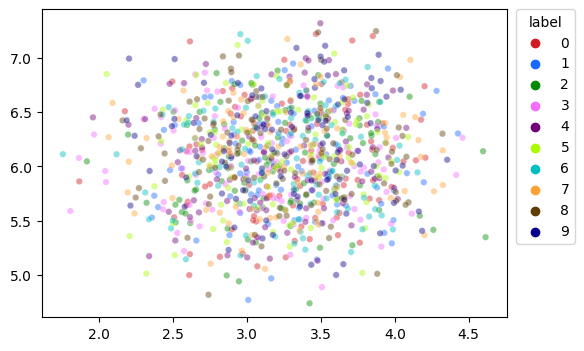

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5246000000000002, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.045647116997535056, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.014333333333333332, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.050260000000000006, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.15084666666666666, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 4.25 s (started: 2022-11-19 20:03:52 -08:00)


In [9]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne", params=dict(repulsion_strength=8.1e6, n_epochs=700, anneal_lr=False)
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("s1k")["evaluations"]

No, it's not supposed to look like that. I don't have any good suggestions currently. One possibility would be to specify a target value for $\bar{Z}$ in terms of $N$, the number of items in the dataset. This corresponds to observations by [Böhm and co-workers](https://www.jmlr.org/papers/v23/21-0055.html) where the final value for the sum of the output kernel weights in t-SNE (used for normalization) is roughly proportional to $N$. Starting with $\bar{Z} = 50{\text -}100 N$ might be a good place to start. For MNIST, $\bar{Z} \approx 115N$ so we could try that with `s1k`:

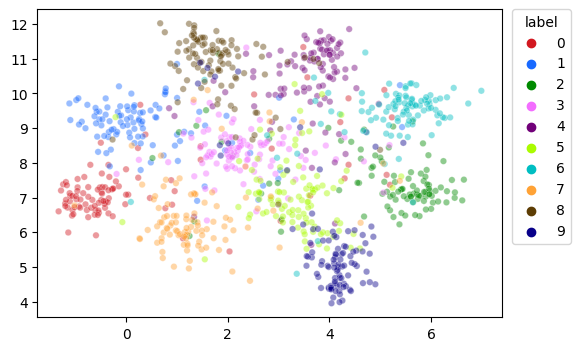

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.596, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.30722514967750386, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.13386666666666666, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.31888, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.44731333333333334, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 3.42 s (started: 2022-11-19 20:03:57 -08:00)


In [10]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne",
        params=dict(repulsion_strength=115 * 1000, n_epochs=700, anneal_lr=False),
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("s1k")["evaluations"]

Actually that came out OK! So for some rough suggestions for `repulsion_strength`:

* t-SNE: $100N$
* NCVis: $500N$
* UMAP: $1000{\text -}5000N$

Let's try it for the UMAP settings:

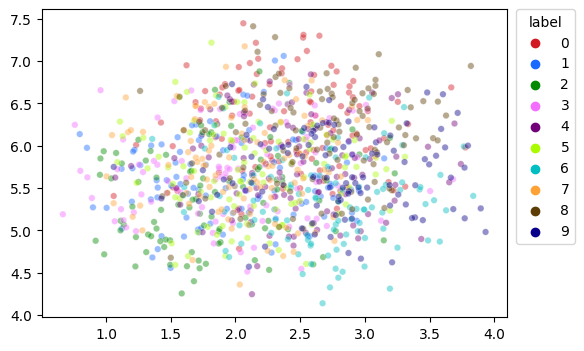

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5316, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.10006023853899101, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.0256, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.07344, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.1874866666666667, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 3.57 s (started: 2022-11-19 20:04:00 -08:00)


In [11]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne",
        params=dict(repulsion_strength=1000 * 1000, n_epochs=700, anneal_lr=False),
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("s1k")["evaluations"]

Is this a learning rate issue? Let's try `anneal_lr=True`:

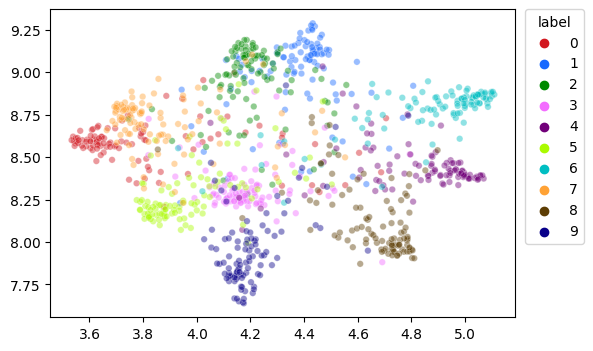

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.63, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.40183970712986733, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.21780000000000002, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.36984000000000006, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.4472133333333333, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 3.43 s (started: 2022-11-19 20:04:04 -08:00)


In [12]:
pl.create_pipeline(
    method=pl.embedder(
        "negtsne",
        params=dict(repulsion_strength=1000 * 1000, n_epochs=700, anneal_lr=True),
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("s1k")["evaluations"]

Based on this, I would suggest either keeping on annealing the learning rate, or experimenting carefully with the value.

## neg-UMAP

This is not a term used in the paper, but it seems like an obvious extension to use the UMAP kernel rather than the Cauchy kernel with the cost which is closest to how UMAP does things, which is not the generalized NCE loss, but the NEG loss function, where $\bar{Z}m\xi=1$ regardless of the data set size or the negative sampling frequence.

This makes the positive and negative parts of the cost:

$$
C^+_{\mathrm{neg{\text -}UMAP}} = - \log \left( \frac{w_{ij}}{w_{ij} + 1} \right) \\
C^-_{\mathrm{neg{\text -}UMAP}} = -\log \left( 1 - \frac{w_{ij}}{w_{ij} + 1} \right)
$$

Now the kernel is:

$$
w_{ij} = \frac{1}{\left(1 + ad_{ij}^{2b}\right)}
$$

with derivative:

$$
\frac{\partial w_{ij}}{\partial{d_{ij}}} = -2abw_{ij}^2d_{ij}^{2b-1}
$$

and using the derivative for Euclidean distance $\partial{d_{ij}}/\partial{\mathbf{y_i}} = \left(1/d_{ij}\right) \left(\mathbf{y}_i - \mathbf{y}_j\right)$:

$$
\frac{\partial w_{ij}}{\partial{\mathbf{y}_i}} = \frac{-2abw_{ij}^2d_{ij}^{2b}}{d_{ij}^2}
$$

The force constants for this gradient are:

$$
k^{+}_{ij} = \frac{2 a b w_{ij} d_{ij}^{2b}}{\left(w_{ij} + 1\right)d_{ij}^{2}} \\
k^{-}_{ij} = -\frac{2 a b w_{ij}^2 d_{ij}^{2b}}{\left(w_{ij} + 1\right)d_{ij}^{2}}
$$

For the Cauchy kernel, $a=1, b=1$, these force constants cancel nicely and give you the neg-t-SNE force constant, with $\bar{Z}m\xi = 1$, which is what you would expect for UMAP. If you want, you can replace add the $\bar{Z}m\xi$ back into these expressions to get neg-t-SNE with the UMAP kernel, but note that you don't have the numerical stability: except when $b=1$ you are left with a $d_{ij}^{2b}$ term in the denominator, so you need to add on a small value to prevent division by zero, just as with the standard UMAP implementation. Also, because UMAP is insensitive to $m$ and $\xi$ it might be more in keeping with UMAP (and more pragmatic) to bundle those parameters into one, let's call it $\gamma = \bar{Z}m\xi$. Then the force constants are:

$$
k^{+}_{ij} = \frac{2 \gamma a b w_{ij} d_{ij}^{2b}}{\left(w_{ij} + \gamma\right)d_{ij}^{2}} \\
k^{-}_{ij} = -\frac{2 a b w_{ij}^2 d_{ij}^{2b}}{\left(w_{ij} + \gamma\right)d_{ij}^{2}}
$$

but you now have the issue that if you set $\gamma \neq 1$, (e.g. something like $\gamma = 0.02$ might be t-SNE-ish) you have to spend time initializing with $\gamma = 1$, so you need to increase the number of epochs you are running for, just like with neg-t-SNE. At least neg-t-SNE doesn't also make you think about setting $a$ and $b$ parameters, but it *will* make you think about setting $\bar{Z}$ and whether to anneal the learning rate or not.

### Implementation

* `repulsion_strength`: use this to set $\gamma$.
* `a`, `b`: same as with UMAP and same defaults.
* `anneal_lr`: unlike neg-t-SNE, this is set to `False` by default. There doesn't seem to be a strong reason to set this to `True` unless you set `gamma` to a value very different from 1, but there may be more danger here of divergence than with neg-t-SNE.

As with neg-t-SNE for the first 200 epochs, $\gamma = 1$, so set `n_epochs` higher to account for that.

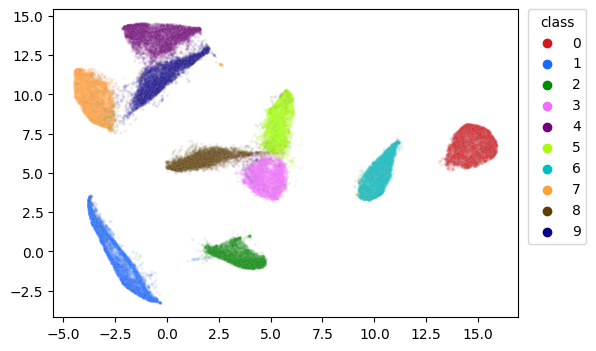

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6117628571428572, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3465940933030841, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.10129904761904761, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.16252542857142857, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2462500952380952, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 31.8 s (started: 2022-11-19 20:04:07 -08:00)


In [13]:
negumap_pipeline = pl.create_pipeline(
    method=pl.embedder("negumap"),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
)

negumap_pipeline.run("mnist")["evaluations"]

There is also a specialized `negtumap` embedder for the Cauchy case, which should be faster due to the much simpler gradient, although the cost of neighbor calculation and the evaluation step is going to dominate most of the runtime for the pipelines used here.

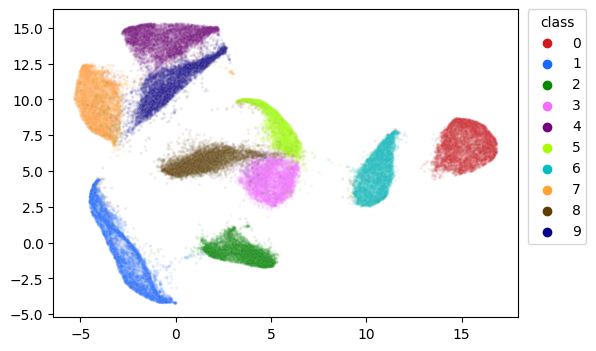

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.61604, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3571277808296502, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.09479809523809524, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.15380257142857143, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2371211428571429, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 27.6 s (started: 2022-11-19 20:04:39 -08:00)


In [14]:
pl.create_pipeline(
    method=pl.embedder("negtumap"),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

And here's an attempt to generate a neg-t-SNE-style result by turning down $\gamma$ (and turning off learning rate annealing):

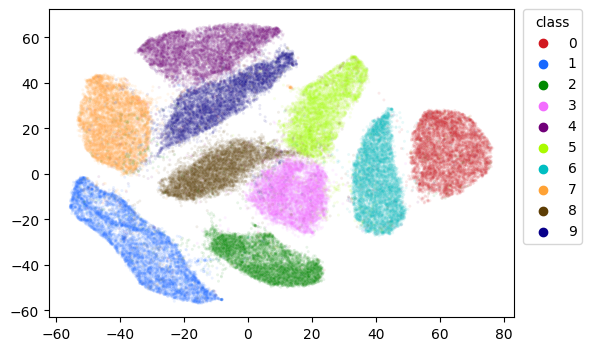

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6105885714285715, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.32699843202046885, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.11411142857142856, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.17557228571428574, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.25892038095238096, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min 1s (started: 2022-11-19 20:05:07 -08:00)


In [15]:
pl.create_pipeline(
    method=pl.embedder(
        "negumap",
        params=dict(
            repulsion_strength=0.015,
            n_epochs=700,
            anneal_lr=False,
        ),
    ),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
).run("mnist")["evaluations"]

Seems ok if you like that sort of thing. No apparent sign of divergence either, but the usual UMAP safeguards (adding a small value to the denonimator, clipping the gradient) are present in the code.